# Spatial Data Lab

## NYC Data Component
During the lesson, we looked at each borough of NYC, drew random samples, and assessed whether these samples fell inside each borough, the convex hull of each borough, or the envelope of each borough.

Generate 10,000 samples uniformly across the NYC map. (Note, you're generating both a random X and a random Y in order to get a location on the NYC map, much like we did when we estimated the value of $\pi$ with the "grains of sand.") Also generate the convex hull and envelope of each borough.

In [3]:
# basic stuff
import os
import pandas as pd
import numpy as np
from random import randint, uniform
from datetime import datetime
from urllib import urlretrieve
from zipfile import ZipFile
import pysal

# geo stuff
import geopandas as gpd
from shapely.geometry import Point
# from ipyleaflet import (Map,
#     Marker,
#     TileLayer, ImageOverlay,
#     Polyline, Polygon, Rectangle, Circle, CircleMarker,
#     GeoJSON,
#     DrawControl
# )

# plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (10.0, 10.0)

# widget stuff
from ipywidgets import interact, HTML, FloatSlider
from IPython.display import clear_output, display

# progress stuff
from tqdm import tqdm_notebook, tqdm_pandas

# turn warnings off
import warnings
warnings.filterwarnings('ignore')

In [1]:
def get_nyc_shape_file(url, filename):

    # download file
    zipped = filename + '.zip'
    urlretrieve('https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile', zipped)
    zipped = os.getcwd() + '/' + zipped

    # unzip file
    to_unzip = ZipFile(zipped, 'r')
    unzipped = os.getcwd() + '/' + filename + '_unzipped'
    to_unzip.extractall(unzipped)
    to_unzip.close()

    # get shape file
    for file in os.listdir(unzipped):
        if file.endswith(".shp"):
            shape_file =  unzipped + '/' + file

    # return full file path
    return shape_file

In [4]:
# get shape file path
shape_file_url = 'https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile'
shape_file_dir = 'nyc_boroughs'
file_path = get_nyc_shape_file(shape_file_url,shape_file_dir)

In [5]:
# read and view GeoDataFrame
gdf = gpd.GeoDataFrame.from_file(file_path)
gdf.head()

,boro_code,boro_name,geometry,shape_area,shape_leng
0,4.0,Queens,(POLYGON ((-73.83668274106707 40.5949466970158...,3.044822e+09,895732.898001
1,5.0,Staten Island,(POLYGON ((-74.05050806403247 40.5664220341608...,1.623818e+09,330694.929182
2,2.0,Bronx,(POLYGON ((-73.89680883223774 40.7958084451597...,1.186671e+09,464417.585525
3,3.0,Brooklyn,(POLYGON ((-73.86706149472118 40.5820879767934...,1.937487e+09,741109.423748
4,1.0,Manhattan,(POLYGON ((-74.01092841268031 40.6844914725429...,6.364538e+08,358410.590999


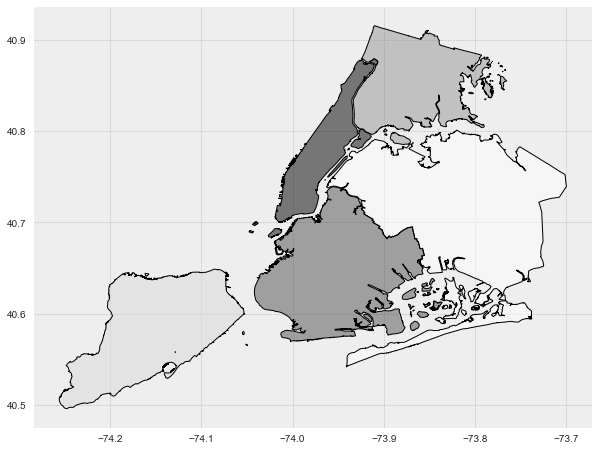

In [6]:
# plot GeoDataFrame
gdf.plot()

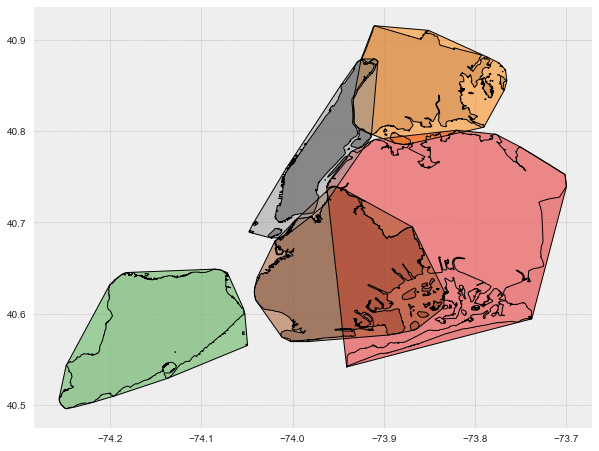

In [7]:
# creating convex hulls
hulls = gdf['geometry'].convex_hull

# plot overlay
hulls.plot(ax=gdf.plot())

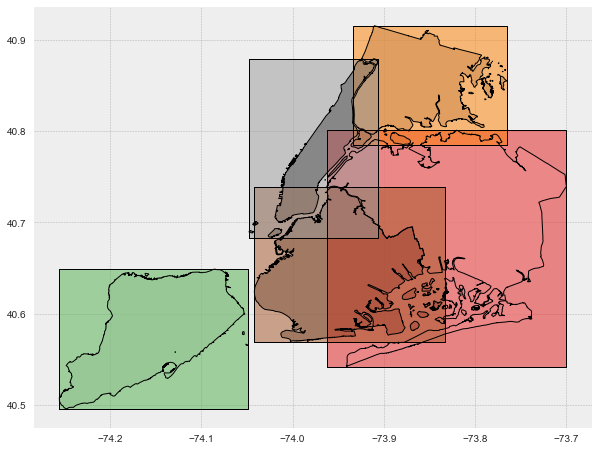

In [8]:
# creating envelopes
envelope = gpd.GeoSeries(hulls.envelope)

# plot overlay
envelope.plot(ax=gdf.plot())

In [14]:
def sim_users(n, p, f):

    # create datetime range
    today = datetime.today().strftime("%m/%d/%Y")
    rng = pd.date_range(today, periods=p, freq=f)

    # get min/max coordinates
    min_x, min_y = gdf['geometry'].bounds.ix[:,:2].min()
    max_x, max_y = gdf['geometry'].bounds.ix[:,2:].max()

    # iterate over time datetime range and create user list
    sim_user_list = []
    for ts in tqdm_notebook(rng, desc='Progress', leave=True):
        for j in xrange(n):
            x = uniform(min_x, max_x)
            y = uniform(min_y, max_y)
            point = Point(x, y)
            gender = randint(0, 1)
            sim_user_list.append([ts, x, y, point, gender])

    # return dataframe
    sim_user_df = pd.DataFrame(sim_user_list, columns=['datetime', 'x', 'y', 'point', 'gender'])
    return sim_user_df

# simulate user data
sim_data = sim_users(100, 24, 'H')
sim_data.head()

,datetime,x,y,point,gender
0,2017-08-17,-74.254131,40.886024,POINT (-74.25413061476536 40.88602365631701),0
1,2017-08-17,-74.170481,40.527827,POINT (-74.1704811462097 40.52782685287162),1
2,2017-08-17,-74.206099,40.515105,POINT (-74.20609886697567 40.51510516600263),0
3,2017-08-17,-74.134837,40.834769,POINT (-74.13483721955016 40.83476948772951),0
4,2017-08-17,-73.749960,40.635616,POINT (-73.74996039466147 40.63561609035733),0


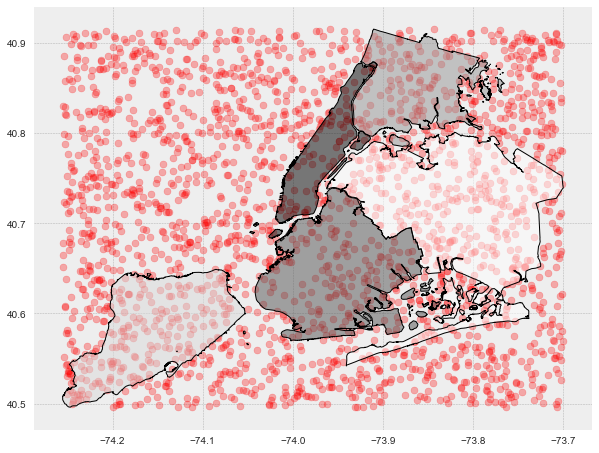

In [15]:
# plot simulated data points
gdf.plot()
plt.scatter(x=sim_data['x'], y=sim_data['y'], alpha=0.3, c='r')

In this part, we'll quantify efficiency. While timing your code, check how long it takes for your computer to check:

- Whether or not each sample falls in the true geographic boroughs.
- Whether or not each sample falls in the convex hulls of the boroughs.
- Whether or not each sample falls in the envelopes of the boroughs.

(Check the linear algebra lesson on computational efficiency for commands for timing code.)

Report these numbers, as well as how much more efficient (percentage-wise) envelopes and convex hulls are relative to the true geographies.

In [17]:
import time

In [16]:
# check if point(s) fall within known geometry - actual
sim_data['contains_1'] = sim_data['point'].map(lambda x: True if gdf.contains(x).any()==True else False)

In [19]:
sim_data['contains_1'].head(10)

0    False
1     True
2     True
3    False
4     True
5     True
6    False
7    False
8     True
9    False
Name: contains_1, dtype: bool

In [20]:
# check if point(s) fall within known geometry - convex hulls
t0 = time.time()

sim_data['contains_2'] = sim_data['point'].map(lambda x: True if hulls.contains(x).any()==True else False)

print time.time() - t0

0.613646030426


In [22]:
sim_data

,datetime,x,y,point,gender,contains_1,contains_2,contains_3
0,2017-08-17 00:00:00,-74.254131,40.886024,POINT (-74.25413061476536 40.88602365631701),0,False,False,False
1,2017-08-17 00:00:00,-74.170481,40.527827,POINT (-74.1704811462097 40.52782685287162),1,True,True,True
2,2017-08-17 00:00:00,-74.206099,40.515105,POINT (-74.20609886697567 40.51510516600263),0,True,True,True
3,2017-08-17 00:00:00,-74.134837,40.834769,POINT (-74.13483721955016 40.83476948772951),0,False,False,False
4,2017-08-17 00:00:00,-73.749960,40.635616,POINT (-73.74996039466147 40.63561609035733),0,True,True,True
5,2017-08-17 00:00:00,-73.802170,40.714623,POINT (-73.80216962702929 40.71462323136241),1,True,True,True
6,2017-08-17 00:00:00,-73.704879,40.574564,POINT (-73.70487880747837 40.57456444255299),0,False,False,True
7,2017-08-17 00:00:00,-74.005929,40.553232,POINT (-74.00592909870086 40.55323170587091),1,False,False,False
8,2017-08-17 00:00:00,-74.231888,40.550410,POINT (-74.23188776025881 40.55041043091733),0,True,True,True
9,2017-08-17 00:00:00,-73.891565,40.777623,POINT (-73.8915645467785 40.77762304180141),0,False,True,True


In [21]:
# check if point(s) fall within known geometry - envelopes

t0 = time.time()
sim_data['contains_3'] = sim_data['point'].map(lambda x: True if envelope.contains(x).any()==True else False)

print time.time() - t0

0.399427175522


Obviously there's a trade-off here. Check how many samples lie in the actual geographies, the convex hulls, and the envelopes.

Report the following:

- A confusion matrix comparing convex hulls and actual geographies. (i.e. actual geographies are the true counts; convex hulls are predicted counts)
- A confusion matrix comparing envelopes and actual geographies.
- The accuracy, sensitivity, and specificity from each of the confusion matrices above.
- A paragraph summarizing your findings.

Accuracy:  0.89
Precision:  0.880434782609


Confusion matrix, without normalization
                                          Lies Within Geography Does Not Lie Within Geography
            Lies Within Geography                        1296.0                         264.0
    Does Not Lie Within Geography                           0.0                         840.0


Normalized confusion matrix
                                          Lies Within Geography Does Not Lie Within Geography
            Lies Within Geography                           0.8                           0.2
    Does Not Lie Within Geography                           0.0                           1.0


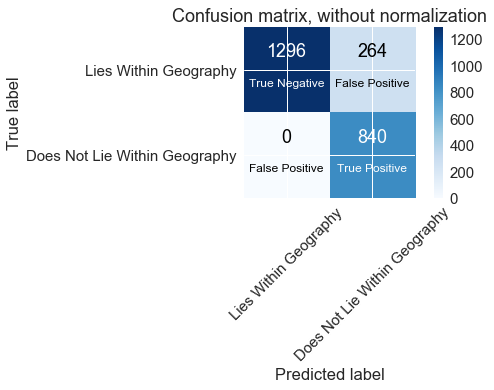

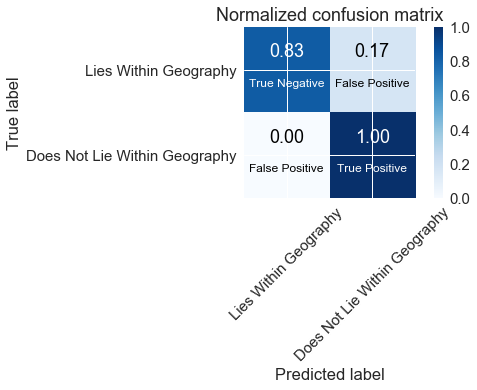

In [24]:
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score

#CHANGE BELOW*****

y_pred = sim_data['contains_2']
y_test = sim_data['contains_1']
class_names = ['Lies Within Geography', 'Does Not Lie Within Geography']

#CHANGE ABOVE*****

#Set font and graph size
sns.set(font_scale=1.5)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

def print_cm(cm, labels=class_names, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels]+[5]) # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print "    " + empty_cell,
    for label in labels: 
        print "%{0}s".format(columnwidth) % label,
    print
    # Print rows
    for i, label1 in enumerate(labels):
        print "    %{0}s".format(columnwidth) % label1,
        for j in range(len(labels)): 
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print cell,
        print

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print '\n'
        print("Normalized confusion matrix")
    else:
        print '\n'
        print('Confusion matrix, without normalization')
    
    print_cm(cm)
    
    text_labels = [['True Negative', 'False Positive'], 
                   ['False Positive', 'True Positive']]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j , i - 0.1, format(cm[i, j], fmt),
                 verticalalignment='bottom',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        plt.text(j, i + 0.1, text_labels[i][j], 
                 verticalalignment='top',
                 horizontalalignment="center",
                 fontsize=12,
                 color="white" if cm[i, j] > thresh else "black")
       

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Print accuracy and precision
print 'Accuracy: ', accuracy_score(y_test, y_pred, normalize=True)
print 'Precision: ', precision_score(y_test, y_pred, average='macro')

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Project 5 Component
Pivoting to Project 5, take the data for this project. Generate a map of the world with each country shaded based on the number of terror attacks that occur in each country. (Warning: Some data munging is likely necessary here.)

In [32]:
terrorism_df = pd.read_csv('/Users/elutins/Desktop/GA/Project5/globalterrorismdb_0617dist.csv')

In [35]:
# initial EDA
terrorism_df.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


In [36]:
terrorism_df.describe()

,eventid,iyear,imonth,iday,extended,country,region,latitude,longitude,specificity,...,ransomamt,ransomamtus,ransompaid,ransompaidus,hostkidoutcome,nreleased,INT_LOG,INT_IDEO,INT_MISC,INT_ANY
count,1.703500e+05,170350.000000,170350.000000,170350.000000,170350.000000,170350.000000,170350.000000,165744.000000,165744.000000,170346.000000,...,1.279000e+03,4.960000e+02,7.070000e+02,487.000000,9911.000000,9322.000000,170350.000000,170350.000000,170350.000000,170350.000000
mean,2.001776e+11,2001.709997,6.474365,15.466845,0.043634,132.526669,7.091441,23.399774,26.350909,1.454428,...,3.224502e+06,4.519918e+05,3.849663e+05,272.462012,4.624458,-28.717335,-4.583387,-4.510555,0.091083,-3.975128
std,1.314444e+09,13.144146,3.392364,8.817929,0.204279,112.848161,2.949206,18.844885,58.570068,1.009005,...,3.090625e+07,6.070186e+06,2.435027e+06,3130.068208,2.041008,58.737198,4.542694,4.630440,0.583166,4.691492
min,1.970000e+11,1970.000000,0.000000,0.000000,0.000000,4.000000,1.000000,-53.154613,-176.176447,1.000000,...,-9.900000e+01,-9.900000e+01,-9.900000e+01,-99.000000,1.000000,-99.000000,-9.000000,-9.000000,-9.000000,-9.000000
25%,1.990053e+11,1990.000000,4.000000,8.000000,0.000000,75.000000,5.000000,11.263580,2.396199,1.000000,...,0.000000e+00,0.000000e+00,-9.900000e+01,0.000000,2.000000,-99.000000,-9.000000,-9.000000,0.000000,-9.000000
50%,2.007121e+11,2007.000000,6.000000,15.000000,0.000000,98.000000,6.000000,31.472680,43.130000,1.000000,...,1.420000e+04,0.000000e+00,0.000000e+00,0.000000,4.000000,0.000000,-9.000000,-9.000000,0.000000,0.000000
75%,2.014023e+11,2014.000000,9.000000,23.000000,0.000000,160.000000,10.000000,34.744167,68.451297,1.000000,...,4.000000e+05,0.000000e+00,7.356800e+02,0.000000,7.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,2.017013e+11,2016.000000,12.000000,31.000000,1.000000,1004.000000,12.000000,74.633553,179.366667,5.000000,...,1.000000e+09,1.320000e+08,4.100000e+07,48000.000000,7.000000,1201.000000,1.000000,1.000000,1.000000,1.000000


In [44]:
terrorism_df['attacktype1'].isnull().sum()

0

In [46]:
terrorism_df['country_txt'].isnull().sum()

0

In [47]:
terrorism_df['attacktype1_txt'].isnull().sum()

0

In [ ]:
terrorism_df.plot()

In [ ]:
terrorism_df

Suppose I want to forecast the number of terror attacks by country. Would this process be described as areal, geostatistical, or point pattern?

Build a widget that will put dots on the map for the location of each terror attack by year. Depending on how precisely you wish to identify the location of the terror attack, you may use the centroid of a country if you'd like. (Note: Using the centroid may cause multiple dots to overlap; people often use a [random jitter](https://www.dataplusscience.com/TableauJitter.html) to help with this. While not required for this lab, consider random jitter as a bonus!)

Suppose I want to predict the precise location of terror attacks. Would this process be described as areal, geostatistical, or point pattern?

### If you're happy with the results here, you should consider including these in your presentations next week!